In [1]:
!pip install -q transformers datasets accelerate scikit-learn seaborn matplotlib
import os, gc, torch
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()


In [2]:
import pandas as pd

# Files already visible in /content per your screenshot
p_5971   = "/content/5971.csv"
p_bangla = "/content/Bangla.csv"
p_comb   = "/content/combined_phishing_dataset.csv"
p_ml     = "/content/multilang_phishing_dataset.csv"
p_synth  = "/content/multilingual_synthetic_hi_te_kn_ta_4000.csv"
p_spam   = "/content/spam.csv"
p_fb     = "/content/feedback_log.csv"  # optional if present

# Robust CSV reader to handle mixed encodings and bad lines
def safe_read_csv(path):
    for enc in ["utf-8", "latin-1", "cp1252", "utf-8-sig"]:
        try:
            return pd.read_csv(path, encoding=enc, on_bad_lines="skip", engine="python")
        except UnicodeDecodeError:
            continue
    # Final fallback without explicit encoding
    return pd.read_csv(path, on_bad_lines="skip", engine="python")


In [3]:
frames = []

# 5971.csv: LABEL/TEXT or v1/v2
df = safe_read_csv(p_5971)
df.columns = [c.strip().lower() for c in df.columns]
if {"label","text"}.issubset(df.columns):
    df1 = df[["text","label"]].copy()
    if df1["label"].dtype == object:
        df1["label"] = df1["label"].str.lower().map({"ham":0,"spam":1})
elif {"v1","v2"}.issubset(df.columns):
    df1 = df.rename(columns={"v2":"text","v1":"label"})[["text","label"]].copy()
    df1["label"] = df1["label"].astype(str).str.lower().map({"ham":0,"spam":1})
else:
    raise ValueError("5971.csv: expected label/text or v1/v2")
df1 = df1.dropna().astype({"label":"int"}); df1["lang"]="en"; frames.append(df1)

# Bangla.csv: label in {smish,promo,normal}
df = safe_read_csv(p_bangla)
df.columns = [c.strip().lower() for c in df.columns]
if {"text","label"}.issubset(df.columns):
    df2 = pd.DataFrame({
        "text":  df["text"].astype(str),
        "label": df["label"].astype(str).str.lower().map({"smish":1,"promo":1,"normal":0})
    }).dropna()
    df2 = df2.astype({"label":"int"}); df2["lang"]="bn"; frames.append(df2)
else:
    raise ValueError("Bangla.csv: expected text,label")

# combined_phishing_dataset.csv: numeric label, text
df = safe_read_csv(p_comb)
df.columns = [c.strip().lower() for c in df.columns]
if {"text","label"}.issubset(df.columns):
    df3 = df[["text","label"]].copy()
    df3["label"] = pd.to_numeric(df3["label"], errors="coerce").round().astype("Int64")
    df3 = df3.dropna().astype({"label":"int"}); df3["lang"]="en"; frames.append(df3)
else:
    raise ValueError("combined_phishing_dataset.csv: expected text,label")

# multilang_phishing_dataset.csv: text,label,(lang)
df = safe_read_csv(p_ml)
df.columns = [c.strip().lower() for c in df.columns]
if {"text","label"}.issubset(df.columns):
    df4 = df[["text","label"]].copy()
    df4["label"] = pd.to_numeric(df4["label"], errors="coerce").round().astype("Int64")
    df4 = df4.dropna().astype({"label":"int"})
    df4["lang"] = df.get("lang","en"); frames.append(df4)
else:
    raise ValueError("multilang_phishing_dataset.csv: expected text,label")

# multilingual_synthetic_hi_te_kn_ta_4000.csv: text,label,(lang)
df = safe_read_csv(p_synth)
df.columns = [c.strip().lower() for c in df.columns]
if {"text","label"}.issubset(df.columns):
    df5 = df[["text","label"]].copy()
    df5["label"] = pd.to_numeric(df5["label"], errors="coerce").round().astype("Int64")
    df5 = df5.dropna().astype({"label":"int"})
    df5["lang"] = df.get("lang","en"); frames.append(df5)
else:
    raise ValueError("multilingual_synthetic_hi_te_kn_ta_4000.csv: expected text,label")

# spam.csv: UCI format v1/v2 or already label/text
df = safe_read_csv(p_spam)
df.columns = [c.strip().lower() for c in df.columns]
if {"v1","v2"}.issubset(df.columns):
    df6 = df.rename(columns={"v2":"text","v1":"label"})[["text","label"]].copy()
    df6["label"] = df6["label"].astype(str).str.lower().map({"ham":0,"spam":1})
elif {"label","text"}.issubset(df.columns):
    df6 = df[["text","label"]].copy()
    df6["label"] = pd.to_numeric(df6["label"], errors="coerce").round().astype("Int64")
else:
    raise ValueError("spam.csv: expected v1/v2 or label/text")
df6 = df6.dropna().astype({"label":"int"}); df6["lang"]="en"; frames.append(df6)

# Optional feedback_log.csv: text, correct_label
try:
    df = safe_read_csv(p_fb)
    df.columns = [c.strip().lower() for c in df.columns]
    if {"text","correct_label"}.issubset(df.columns):
        lab = df["correct_label"]
        if lab.dtype == object:
            lab = lab.astype(str).str.lower().map({"phishing":1,"spam":1,"safe":0,"ham":0})
        lab = pd.to_numeric(lab, errors="coerce").round().astype("Int64")
        df7 = pd.DataFrame({"text":df["text"].astype(str), "label":lab}).dropna()
        df7 = df7.astype({"label":"int"}); df7["lang"]="en"; frames.append(df7)
except Exception:
    pass

df_all = pd.concat(frames, ignore_index=True)
df_all = df_all.drop_duplicates(subset=["text"]).dropna(subset=["text","label"])
df_all["label"] = df_all["label"].astype(int)
print("Merged:", df_all.shape)
print("Labels:\n", df_all["label"].value_counts())
print("Langs:\n", df_all["lang"].value_counts())


Merged: (8781, 3)
Labels:
 label
0    5986
1    2795
Name: count, dtype: int64
Langs:
 lang
en    6798
bn    1248
ta     191
kn     190
te     185
hi     169
Name: count, dtype: int64


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/7902 [00:00<?, ? examples/s]

Map:   0%|          | 0/879 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.063100,0.076936,0.984073,0.961806,0.989286,0.975352
2,0.103800,0.047522,0.989761,0.985663,0.982143,0.983900


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.063100,0.076936,0.984073,0.961806,0.989286,0.975352
2,0.103800,0.047522,0.989761,0.985663,0.982143,0.983900
3,0.020700,0.052509,0.989761,0.985663,0.982143,0.983900


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.04752194508910179, 'eval_accuracy': 0.9897610921501706, 'eval_precision': 0.985663082437276, 'eval_recall': 0.9821428571428571, 'eval_f1': 0.9838998211091234, 'eval_runtime': 355.8265, 'eval_samples_per_second': 2.47, 'eval_steps_per_second': 0.079, 'epoch': 3.0}


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


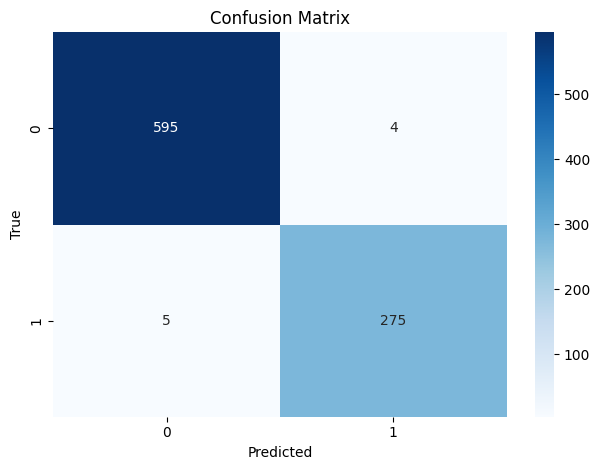

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       599
           1       0.99      0.98      0.98       280

    accuracy                           0.99       879
   macro avg       0.99      0.99      0.99       879
weighted avg       0.99      0.99      0.99       879



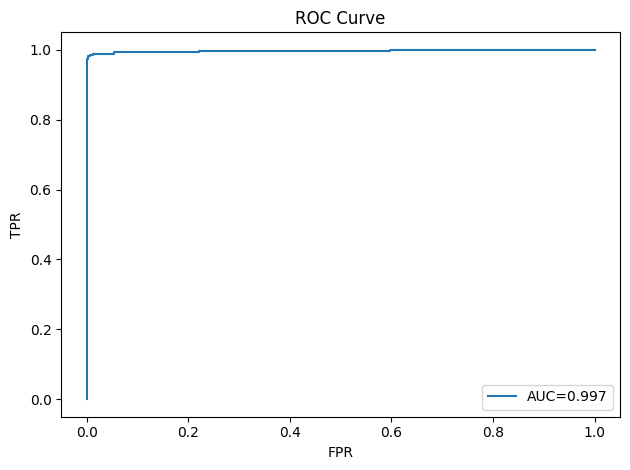

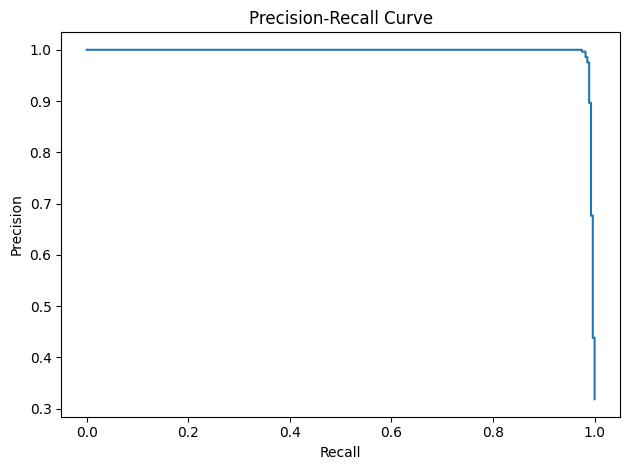

In [4]:
# 4) Split and build Hugging Face Datasets
from sklearn.model_selection import train_test_split
from datasets import Dataset

train_df, eval_df = train_test_split(
    df_all[["text","label"]],
    test_size=0.1, random_state=42, stratify=df_all["label"]
)
train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
eval_ds  = Dataset.from_pandas(eval_df.reset_index(drop=True))

# 5) Tokenize, fine-tune XLM-RoBERTa, and evaluate
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import torch

model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)  # Auto* classes [web:624]
model     = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)  # binary head [web:562]

def tok(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

train_ds = train_ds.map(tok, batched=True, remove_columns=["text"])  # map/tokenize [web:567]
eval_ds  = eval_ds.map(tok,  batched=True, remove_columns=["text"])  # map/tokenize [web:567]
train_ds.set_format("torch", columns=["input_ids","attention_mask","label"])
eval_ds.set_format("torch",  columns=["input_ids","attention_mask","label"])

def compute_metrics(p):
    logits, labels = p
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy":  accuracy_score(labels, preds),
        "precision": precision_score(labels, preds),
        "recall":    recall_score(labels, preds),
        "f1":        f1_score(labels, preds),
    }

args = TrainingArguments(
    output_dir="/content/out",
    eval_strategy="epoch",                   # per-epoch eval [web:562]
    save_strategy="epoch",                   # per-epoch save [web:562]
    learning_rate=2e-5,
    per_device_train_batch_size=16,          # lower if OOM [web:562]
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=10,
    load_best_model_at_end=True,             # keep best [web:562]
    metric_for_best_model="f1",
    greater_is_better=True,
    save_total_limit=2,
    report_to="none",
    fp16=True                                # mixed precision on GPU [web:562]
)

trainer = Trainer(
    model=model, args=args,
    train_dataset=train_ds, eval_dataset=eval_ds,
    compute_metrics=compute_metrics,
)

trainer.train()                              # standard loop [web:562]
metrics = trainer.evaluate()                 # final eval [web:562]
print(metrics)

# 6) Save best model and produce report plots
trainer.save_model("/content/phishing_model_best")      # save model [web:562]
tokenizer.save_pretrained("/content/phishing_model_best")  # save tokenizer [web:624]

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt, seaborn as sns

pred_out = trainer.predict(eval_ds)          # predictions helper [web:562]
logits = pred_out.predictions
labels = pred_out.label_ids
probs  = torch.softmax(torch.tensor(logits), dim=1).numpy()
preds  = probs.argmax(axis=1)

# Confusion Matrix
cm = confusion_matrix(labels, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.savefig("/content/confusion_matrix.png", dpi=200); plt.show()

# Classification report
print(classification_report(labels, preds))

# ROC
fpr, tpr, _ = roc_curve(labels, probs[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.title("ROC Curve")
plt.tight_layout(); plt.savefig("/content/roc_curve.png", dpi=200); plt.show()

# Precision-Recall
prec, rec, _ = precision_recall_curve(labels, probs[:,1])
plt.plot(rec, prec)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall Curve")
plt.tight_layout(); plt.savefig("/content/pr_curve.png", dpi=200); plt.show()


In [6]:
!zip -r /content/phishing_model_best.zip /content/phishing_model_best
from google.colab import drive
drive.mount('/content/drive')
!cp /content/phishing_model_best.zip "/content/drive/MyDrive/"


  adding: content/phishing_model_best/ (stored 0%)
  adding: content/phishing_model_best/tokenizer.json (deflated 76%)
  adding: content/phishing_model_best/tokenizer_config.json (deflated 74%)
  adding: content/phishing_model_best/training_args.bin (deflated 54%)
  adding: content/phishing_model_best/config.json (deflated 50%)
  adding: content/phishing_model_best/model.safetensors (deflated 28%)
  adding: content/phishing_model_best/special_tokens_map.json (deflated 85%)
  adding: content/phishing_model_best/sentencepiece.bpe.model (deflated 49%)
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# Minimal, low‑memory sanity check while Colab loads the full model

import os, torch, numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification

BEST_DIR = "/content/phishing_model_best"  # or your checkpoint path (e.g., /content/out/checkpoint-XXXX)
assert os.path.isdir(BEST_DIR), f"Model dir not found: {BEST_DIR}. Try: !ls -lah /content"

tokenizer = AutoTokenizer.from_pretrained(BEST_DIR, local_files_only=True)  # local load [web:624]
model = AutoModelForSequenceClassification.from_pretrained(BEST_DIR, local_files_only=True).eval()  # local load [web:624]

def quick_predict(msgs, max_len=128, threshold=0.05):
    enc = tokenizer(msgs, padding=True, truncation=True, max_length=max_len, return_tensors="pt")
    with torch.no_grad():
        probs = torch.softmax(model(**enc).logits, dim=-1).cpu().numpy()
    p1 = probs[:,1]
    preds = (p1 >= threshold).astype(int)
    return [
        {"text": m, "pred": int(y), "label": ("Phishing" if y==1 else "Safe"),
         "prob_safe": float(1 - pp), "prob_phishing": float(pp)}
        for m, pp, y in zip(msgs, p1, preds)
    ]

samples = [
    "Bank statement: Your e‑statement is ready; open your bank’s mobile app and go to Statements; do not share OTP with anyone",
    "Microsoft 365: Your subscription expires today; to avoid mailbox deactivation confirm payment at https://micr0soft-renewal.com or call 1‑888‑555‑1212",
]
print(quick_predict(samples))


[{'text': 'Bank statement: Your e‑statement is ready; open your bank’s mobile app and go to Statements; do not share OTP with anyone', 'pred': 1, 'label': 'Phishing', 'prob_safe': 0.010812342166900635, 'prob_phishing': 0.9891876578330994}, {'text': 'Microsoft 365: Your subscription expires today; to avoid mailbox deactivation confirm payment at https://micr0soft-renewal.com or call 1‑888‑555‑1212', 'pred': 1, 'label': 'Phishing', 'prob_safe': 0.00031936168670654297, 'prob_phishing': 0.9996806383132935}]


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
!pip install -q fastapi "uvicorn[standard]" langdetect transformers sqlalchemy datasets scikit-learn pyngrok


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.8/510.8 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.2/452.2 kB 25.2 MB/s eta 0:00:00


In [21]:
import requests, json
BASE = "https://compressed-steel-bandwidth-parents.trycloudflare.com"
print(requests.get(BASE+"/health").json())

r = requests.post(BASE+"/predict", json={"default_lang":"kn","text":"ನಿಮ್ಮ OTP 654321. ಯಾರೊಂದಿಗೆ ಹಂಚಿಕೊಳ್ಳಬೇಡಿ."})
res = r.json(); print(res)

# store feedback (0=safe, 1=phishing)
fb = requests.post(BASE+"/feedback", json={"message_id": res["message_id"], "correct_label": 1}).json()
print(fb)

# optional: background head-only fine-tune
print(requests.post(BASE+"/train").json())


INFO:     35.221.195.183:0 - "GET /health HTTP/1.1" 200 OK
{'ok': True, 'model_dir': '/content/phishing_model_best', 'threshold': 0.05, 'db': 'sqlite:////content/phish.db'}
INFO:     35.221.195.183:0 - "POST /predict HTTP/1.1" 200 OK
{'message_id': 1, 'default_lang': 'kn', 'detected_lang': 'kn', 'pred_label': 1, 'prob_phishing': 0.9993558526039124, 'prob_safe': 0.000644200830720365, 'alert_text': 'ಫಿಶಿಂಗ್ ಅನುಮಾನ! ಲಿಂಕ್\u200cಗಳನ್ನು ತಪ್ಪಿಸಿ.'}
INFO:     35.221.195.183:0 - "POST /feedback HTTP/1.1" 200 OK
{'ok': True, 'message_id': 1, 'feedback': 1}
INFO:     35.221.195.183:0 - "POST /train HTTP/1.1" 200 OK
{'started': True, 'queued_items': 1}


In [22]:
import requests, json
BASE="https://compressed-steel-bandwidth-parents.trycloudflare.com"  # replace with your printed URL
tests=[
    {"default_lang":"kn","text":"ನಿಮ್ಮ ಬ್ಯಾಂಕ್ KYC ಇಂದು ಕೊನೆಯ ದಿನ; ಲಾಗಿನ್ ಮಾಡಿ ದೃಢೀಕರಿಸಿ"},
    {"default_lang":"kn","text":"ನಾಳೆ 4 ಗಂಟೆಗೆ ಸಭೆ ಇದೆ. ದಯವಿಟ್ಟು 10 ನಿಮಿಷ ಮುಂಚಿತವಾಗಿ ಬನ್ನಿ."},
]
for p in tests:
    r=requests.post(BASE+"/predict", json=p); res=r.json(); print(res)


INFO:     35.221.195.183:0 - "POST /predict HTTP/1.1" 200 OK
{'message_id': 2, 'default_lang': 'kn', 'detected_lang': 'kn', 'pred_label': 1, 'prob_phishing': 0.9970113039016724, 'prob_safe': 0.0029886842239648104, 'alert_text': 'ಫಿಶಿಂಗ್ ಅನುಮಾನ! ಲಿಂಕ್\u200cಗಳನ್ನು ತಪ್ಪಿಸಿ.'}
INFO:     35.221.195.183:0 - "POST /predict HTTP/1.1" 200 OK
{'message_id': 3, 'default_lang': 'kn', 'detected_lang': 'kn', 'pred_label': 0, 'prob_phishing': 0.00015514870756305754, 'prob_safe': 0.9998447895050049, 'alert_text': 'ಈ ಸಂದೇಶವು ಸುರಕ್ಷಿತವಾಗಿದೆ ಎಂದು ಕಾಣುತ್ತದೆ.'}


In [2]:
!pip install -q gradio transformers langdetect datasets scikit-learn sqlalchemy

import os, sqlite3, torch, numpy as np, gradio as gr
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from langdetect import detect, DetectorFactory

# --- Config ---
MODEL_DIR = "/content/content/phishing_model_best"  # change if needed
THRESHOLD = float(os.getenv("THRESHOLD", "0.05"))
DB_PATH = "/content/phish.db"

# --- UI strings ---
ui_alerts = {
    "en": {"safe":"This message appears safe.","phish":"Phishing suspected! Avoid links."},
    "hi": {"safe":"यह संदेश सुरक्षित लगता है।","phish":"फ़िशिंग संदिग्ध! लिंक से बचें।"},
    "ta": {"safe":"இந்த செய்தி பாதுகாப்பாகத் தெரிகிறது.","phish":"ஃபிஷிங் சந்தேகம்! இணைப்புகளைத் தவிர்க்கவும்."},
    "te": {"safe":"ఈ సందేశం సురక్షితంగా కనిపిస్తోంది.","phish":"ఫిషింగ్ అనుమానం! లింకులను నివారించండి."},
    "kn": {"safe":"ಈ ಸಂದೇಶವು ಸುರಕ್ಷಿತವಾಗಿದೆ ಎಂದು ಕಾಣುತ್ತದೆ.","phish":"ಫಿಶಿಂಗ್ ಅನುಮಾನ! ಲಿಂಕ್‌ಗಳನ್ನು ತಪ್ಪಿಸಿ."},
    "bn": {"safe":"এটি নিরাপদ বার্তা বলে মনে হচ্ছে।","phish":"ফিশিং সন্দেহ! লিঙ্ক এড়িয়ে চলুন।"},
}
supported_langs = set(ui_alerts.keys())

# --- Init model & langdetect ---
assert os.path.isdir(MODEL_DIR), f"MODEL_DIR not found: {MODEL_DIR}"
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR, local_files_only=True)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR, local_files_only=True).eval()
DetectorFactory.seed = 0

# --- DB setup ---
def db_init():
    con = sqlite3.connect(DB_PATH); cur = con.cursor()
    cur.execute("""CREATE TABLE IF NOT EXISTS messages(
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        ts DATETIME DEFAULT CURRENT_TIMESTAMP,
        default_lang TEXT, detected_lang TEXT, text TEXT,
        pred_label INTEGER, prob_phishing REAL, prob_safe REAL,
        threshold REAL, feedback INTEGER
    )""")
    con.commit(); con.close()
db_init()

def detect_lang(text:str)->str:
    try:
        code = detect(text or "")
        return code if code in supported_langs else "en"
    except Exception:
        return "en"

def classify(text: str):
    enc = tokenizer([text], padding=True, truncation=True, max_length=128, return_tensors="pt")
    with torch.no_grad():
        probs = torch.softmax(model(**enc).logits, dim=-1).cpu().numpy()[0]
    p_safe  = float(probs[0])
    p_phish = float(probs[1])
    if p_phish > 0.5:
        pred = 1
    elif p_safe > 0.5:
        pred = 0
    else:
        pred = int(p_phish >= p_safe)  # tie/uncertain fallback by argmax
    return pred, p_phish, p_safe


def save_message(default_lang, detected_lang, text, pred, p1, p0):
    con = sqlite3.connect(DB_PATH); cur = con.cursor()
    cur.execute("""INSERT INTO messages(default_lang,detected_lang,text,pred_label,prob_phishing,prob_safe,threshold)
                   VALUES(?,?,?,?,?,?,?)""",
                (default_lang, detected_lang, text, pred, p1, p0, THRESHOLD))
    con.commit(); mid = cur.lastrowid; con.close(); return mid

def set_feedback(mid:int, correct:int):
    con = sqlite3.connect(DB_PATH); cur = con.cursor()
    cur.execute("UPDATE messages SET feedback=? WHERE id=?", (int(correct), int(mid)))
    con.commit(); con.close()

def retrain_on_feedback():
    con = sqlite3.connect(DB_PATH); cur = con.cursor()
    rows = list(cur.execute("SELECT text, feedback FROM messages WHERE feedback IS NOT NULL"))
    con.close()
    if not rows: return "No labeled feedback yet."
    texts = [r[0] for r in rows]; labels=[int(r[1]) for r in rows]
    ds = Dataset.from_dict({"text":texts, "label":labels})
    def tok(b): return tokenizer(b["text"], padding="max_length", truncation=True, max_length=128)
    ds = ds.map(tok, batched=True, remove_columns=["text"]); ds.set_format("torch", ["input_ids","attention_mask","label"])
    # freeze backbone, train head
    if hasattr(model, "base_model"):
        for p in model.base_model.parameters(): p.requires_grad=False
    args = TrainingArguments(output_dir="/content/out_feedback", num_train_epochs=1,
                             per_device_train_batch_size=32, learning_rate=2e-4,
                             save_strategy="no", eval_strategy="no", report_to="none",
                             fp16=torch.cuda.is_available())
    trainer = Trainer(model=model, args=args, train_dataset=ds)
    trainer.train()
    model.save_pretrained(MODEL_DIR); tokenizer.save_pretrained(MODEL_DIR)
    return "Retrain complete. Weights updated."

# --- Gradio UI ---
def scan_flow(pref_lang, message):
    pref = pref_lang if pref_lang in supported_langs else "en"
    dlang = detect_lang(message)
    pred, p1, p0 = classify(message)
    mid = save_message(pref, dlang, message, pred, p1, p0)
    alert = ui_alerts[pref]["phish" if pred==1 else "safe"]
    info = f"{alert}\n\nDetected: {dlang}\nLabel: {'Phishing' if pred==1 else 'Safe'}\nP(phish): {p1:.4f}  P(safe): {p0:.4f}\nmessage_id: {mid}"
    return mid, info

def feedback_and_train(mid, label_name):
    if mid is None:
        return "Run a scan first."
    correct = 1 if label_name == "Phishing" else 0
    set_feedback(int(mid), correct)  # store user correction (0/1) in SQLite
    status = retrain_on_feedback()   # head-only fine-tune on all labeled rows
    return f"Feedback saved for message_id={int(mid)}\n{status}"

with gr.Blocks(title="Phishing Detector") as demo:
    gr.Markdown("## Multilingual Phishing Detector")
    lang = gr.Dropdown(choices=list(supported_langs), value="kn", label="Preferred language")
    msg  = gr.Textbox(lines=3, label="Message")
    mid  = gr.Number(label="message_id", interactive=False)
    out  = gr.Textbox(lines=7, label="Result")
    gr.Button("Scan").click(scan_flow, [lang, msg], [mid, out])

    gr.Markdown("### Feedback")
    picked = gr.Radio(choices=["Safe","Phishing"], value="Safe", label="Correct label")
    # Single button now does both: save feedback + train
    gr.Button("Submit Feedback (Save + Train)").click(feedback_and_train, [mid, picked], out)


demo.launch(share=True)  # shows a public link


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://7c52d112990704316a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [3]:
from google.colab import drive
drive.mount('/content/drive')
!cp /content/phish.db "/content/drive/MyDrive/phish.db"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cp: cannot stat '/content/phish.db': No such file or directory


In [1]:
!unzip -o "/content/drive/MyDrive/phishing_model_best_latest.zip" -d "/content/"


Archive:  /content/drive/MyDrive/phishing_model_best_latest.zip
   creating: /content/content/phishing_model_best/
  inflating: /content/content/phishing_model_best/tokenizer.json  
  inflating: /content/content/phishing_model_best/tokenizer_config.json  
  inflating: /content/content/phishing_model_best/training_args.bin  
  inflating: /content/content/phishing_model_best/config.json  
  inflating: /content/content/phishing_model_best/model.safetensors  
  inflating: /content/content/phishing_model_best/special_tokens_map.json  
  inflating: /content/content/phishing_model_best/sentencepiece.bpe.model  


In [10]:
!zip -r /content/phishing_model_best_latest.zip /content/phishing_model_best
from google.colab import drive; drive.mount('/content/drive')
!cp /content/phishing_model_best_latest.zip "/content/drive/MyDrive/"


  adding: content/phishing_model_best/ (stored 0%)
  adding: content/phishing_model_best/tokenizer.json (deflated 76%)
  adding: content/phishing_model_best/tokenizer_config.json (deflated 74%)
  adding: content/phishing_model_best/training_args.bin (deflated 54%)
  adding: content/phishing_model_best/config.json (deflated 50%)
  adding: content/phishing_model_best/model.safetensors (deflated 28%)
  adding: content/phishing_model_best/special_tokens_map.json (deflated 85%)
  adding: content/phishing_model_best/sentencepiece.bpe.model (deflated 49%)
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!cp /content/phish.db "/content/drive/MyDrive/"


cp: cannot stat '/content/phish.db': No such file or directory


In [3]:
!cp /content/app.py "/content/drive/MyDrive/"


cp: cannot stat '/content/app.py': No such file or directory


In [3]:
import sqlite3, pandas as pd
con = sqlite3.connect("/content/phish.db")
df = pd.read_sql("SELECT * FROM messages", con)
con.close()
df.head()


,id,ts,default_lang,detected_lang,text,pred_label,prob_phishing,prob_safe,threshold,feedback
